In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm  
import cvxpy as cp
from scipy.stats import genpareto
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import math 

Datas taken from table 1 , pag 24 

In [3]:
# Initial Liabilities 
liab_value = [1424.2]
liab_duration = [6.6]

# Initial Assets
asset_list = ['gov_bond', 'corp_bond', 'equity_1', 'equity_2', 'property', 't_bills']
asset_total = 1652.7

initial_asset = pd.DataFrame(index=asset_list)
initial_asset['asset_val'] = [782.6, 586, 0, 102.5, 42, 139.6]
initial_asset['asset_dur'] = [5.2, 5.0, 0.0, 0.0, 0.0, 0.1]
initial_asset['asset_ret'] = [0.029, 0.041, 0.064, 0.064, 0.056, 0.006]
initial_asset['asset_weight'] = initial_asset['asset_val'] / initial_asset['asset_val'].sum()

# (optional sanity check, not required for optimization)
initial_portfolio_return = initial_asset['asset_ret'] @ initial_asset['asset_weight']
print("Initial expected return:", initial_portfolio_return)

Initial expected return: 0.03416893568100684


On page 9,10,11, computed from equation 5-6-7-8-9-10

Result are in table 3 pag 24

In [4]:
# Defining the solvency II parameters

int_up_param = 0.011
int_down_param = 0.009
equity_1_param = 0.39
equity_2_param = 0.49
prop_params = 0.25
spread_params = 0.103
rho = 0.75

Before we were treating illiquid assets = corp + equities + property, but in the paper illiquid = equity_1 + equity_2 + property, and corporates have a separate 50% cap.

Summarized in table 4 pag 24, equations 18-19-20-22-22

In [5]:
allocation_limits_data = {
    "asset": [
        "gov_bond",
        "illiquid_assets",
        "t_bills",
        "corp_bond",
    ],
    "description": [
        "Government Bonds",
        "Equities + Property (Illiquid)",
        "Treasury Bills",
        "Corporate Bonds",
    ],
    "min_weight": [
        0.25,   # gov min
        0.0,    # illiquid min
        0.01,   # t-bills min
        0.0,    # corp min
    ],
    "max_weight": [
        0.75,   # gov max
        0.20,   # illiquid max
        0.05,   # t-bills max
        0.50,   # corp max (as in the paper)
    ]
}

allocation_limits = pd.DataFrame(allocation_limits_data).set_index("asset")

#allocation_limits


In the appendix table 8 ad 9 

Aggregation of market risk equation 11

In [6]:
# SCR Market Correlation Matrix (Interest Rate Downward and Upward Scenario)

# Downward

corr_downward = pd.DataFrame(
    [
        [1.0, 0.5, 0.5, 0.5],
        [0.5, 1.0, 0.75, 0.75],
        [0.5, 0.75, 1.0, 0.5],
        [0.5, 0.75, 0.5, 1.0]
    ],
    index=["interest", "equity", "property", "spread"],
    columns=["interest", "equity", "property", "spread"]
)

# Upward
corr_upward = pd.DataFrame(
    [
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.75, 0.75],
        [0.0, 0.75, 1.0, 0.5],
        [0.0, 0.75, 0.5, 1.0]
    ],
    index=["interest", "equity", "property", "spread"],
    columns=["interest", "equity", "property", "spread"]
)


Page 9 , interest rate risk ,  equation 5 

In [7]:
def scr_interest_rate(A, D_A, L, D_L, delta_y_down, delta_y_up):
    """
    Compute Solvency II interest rate risk SCR (formula (1)) directly.
    
    Parameters
    ----------
    A : array-like
        Market values of interest-sensitive assets
    D_A : array-like
        Modified durations of assets
    L : array-like
        Market values of liabilities
    D_L : array-like
        Modified durations of liabilities
    delta_y_down : float
        Downward rate shock magnitude (positive number, e.g. 0.009)
    delta_y_up : float
        Upward rate shock magnitude (positive number, e.g. 0.011)
    """

    A = np.array(A, dtype=float)
    D_A = np.array(D_A, dtype=float)
    L = np.array(L, dtype=float)
    D_L = np.array(D_L, dtype=float)

    asset_sens = np.sum(D_A * A)
    liab_sens = np.sum(D_L * L)

    # losses (always positive)
    loss_down = delta_y_down * (liab_sens - asset_sens)
    loss_up   = delta_y_up   * (asset_sens - liab_sens)

    scr_interest = max(loss_down, loss_up)

    return {
        "SCR_interest": scr_interest,
        "direction": "down" if loss_down >= loss_up else "up"
    }

In [8]:
scr_interest = scr_interest_rate(initial_asset['asset_val'], initial_asset['asset_dur'], 
                                 liab_value, liab_duration, int_down_param, int_up_param)

scr_interest

{'SCR_interest': np.float64(21.47615999999999), 'direction': 'down'}

Page 10 , equity risk  ,equation 6 and 7 

In [9]:

def scr_eq(
    A_eq1: float,
    A_eq2: float,
    shock_eq1: float,
    shock_eq2: float,
    rho: float
):
    """
    Solvency II Equity risk SCR calculation.
    """

    # Individual sub-module SCRs
    SCR1 = shock_eq1 * A_eq1
    SCR2 = shock_eq2 * A_eq2

    # Aggregate using correlation
    SCR_eq = math.sqrt(SCR1**2 + 2 * rho * SCR1 * SCR2 + SCR2**2)

    return {
        "SCR_eq_type1": SCR1,
        "SCR_eq_type2": SCR2,
        "SCR_eq_total": SCR_eq
    }

In [10]:
A_eq1 = initial_asset.loc['equity_1', 'asset_val']
A_eq2 = initial_asset.loc['equity_2', 'asset_val']

scr_equity = scr_eq(A_eq1, A_eq2, shock_eq1=equity_1_param, shock_eq2=equity_2_param, rho=rho)  # equity_1=0, equity_2=102.5

scr_equity


{'SCR_eq_type1': np.float64(0.0),
 'SCR_eq_type2': np.float64(50.225),
 'SCR_eq_total': 50.225}

Propierty risk and spread risk , page 10 and 11

In [11]:
scr_property = prop_params * initial_asset.loc['property', 'asset_val']

scr_spread = spread_params * initial_asset.loc['corp_bond', 'asset_val']

In [12]:
initial_asset

,asset_val,asset_dur,asset_ret,asset_weight
gov_bond,782.6,5.2,0.029,0.473528
corp_bond,586.0,5.0,0.041,0.354571
equity_1,0.0,0.0,0.064,0.000000
equity_2,102.5,0.0,0.064,0.062020
property,42.0,0.0,0.056,0.025413
t_bills,139.6,0.1,0.006,0.084468


•	The correlation matrix depends on whether the interest-rate risk is determined by the downward or upward shock.

•	These matrices are reported in Table 8 and 9

•	In the implementation, the code switches between
corr_downward and corr_upward based on scr_interest["direction"]

cr_total = np.sqrt(vec @ corr @ vec) is a impleantation of equation 11

Diversification output are standard solvency ii reporting items 

In [ ]:
def aggregate_market_scr(
    scr_interest: dict,
    scr_equity: float,
    scr_property: float,
    scr_spread: float,
    corr_down: np.ndarray,
    corr_up: np.ndarray,
):
    """
    Aggregate Market SCR using externally supplied correlation matrices,
    including diversification benefit reporting.
    
    Parameters
    ----------
    scr_interest : dict
        Result of scr_interest_rate(), containing 'loss_down', 'loss_up', 'direction'.
    scr_equity : float
        Total equity SCR.
    scr_property : float
        Property SCR.
    scr_spread : float
        Spread SCR.
    corr_down : ndarray
        Correlation matrix for Panel A (Interest-rate downward).
    corr_up : ndarray
        Correlation matrix for Panel B (Interest-rate upward).

    Returns
    -------
    dict
        Contains summary table and final aggregated results.
    """

    direction   = scr_interest["direction"].lower()

    # Choose correct scenario based on direction 
    vec = np.array([scr_interest['SCR_interest'], 
          scr_equity['SCR_eq_total'], 
          scr_property, 
          scr_spread], dtype=float)
        
    if direction.startswith("down"):
        corr = np.array(corr_downward)
        chosen_panel = "Interest_DOWN"
    else:
        corr = np.array(corr_upward)
        chosen_panel = "Interest_UP"

    # Aggregation
    scr_total = np.sqrt(vec @ corr @ vec)
    scr_sum = np.sum(vec)
    diversification = scr_sum - scr_total
    diversification_pct = 1 - (scr_total / scr_sum) if scr_sum > 0 else 0

    # Summary table
    summary = pd.DataFrame({
        "risk": ["interest", "equity", "property", "spread", "total", "diversification"],
        "SCR": np.append(vec, [scr_total, diversification])
    })

    # Results dictionary
    return {
        "summary_table": summary,
        "chosen_panel": chosen_panel,
        "SCR_market_final": scr_total,
        "Undiversified_sum": scr_sum,
        "Diversification": diversification,
        "Diversification_pct": diversification_pct,
    }


In [14]:
res = aggregate_market_scr(
    scr_interest,
    scr_equity,
    scr_property,
    scr_spread,
    corr_downward,
    corr_upward)

scr_df = res['summary_table']
scr_df = scr_df.set_index('risk')

scr_df

,SCR
risk,
interest,21.476160
equity,50.225000
property,10.500000
spread,60.358000
total,123.731709
diversification,18.827451


In [ ]:
def marginal_scr(
    v: np.ndarray,
    direction: str,
) -> pd.DataFrame:
    """
    Compute marginal and allocated SCRs (Solvency II-style).

    Parameters
    ----------
    v : np.ndarray
        Vector of stand-alone SCRs (1D array).
    direction : str
        Either 'Interest_DOWN' or 'Interest_UP' (controls which correlation matrix is used).
    Returns
    -------
    pd.DataFrame
        Table containing:
        - risk name
        - Stand-alone SCRs
        - Marginal SCR factors 
        - Absolute SCR contribution 
        - Relative SCR contribution (%)
    """

    # Input checks
    
    v = np.asarray(v, dtype=float)

    if direction == 'Interest_DOWN':
        corr = np.asarray(corr_downward, dtype=float)
    else:
        corr = np.asarray(corr_upward, dtype=float)

    if corr.shape[0] != corr.shape[1] or corr.shape[0] != len(v):
        raise ValueError("Correlation matrix must be square and match the size of SCR vector")

    # Core calculations

    scr_total = np.sqrt(v @ corr @ v)           # Diversified total SCR
    marginals = (corr @ v) / scr_total          # Marginal SCR factors (M_i)
    allocated = v * marginals                   # Absolute SCR contribution
    share_pct = 100 * allocated / scr_total     # Relative SCR contribution (%)

    # Results table

    df = pd.DataFrame({
        "risk": ["interest", "equity", "property", "spread"],
        "SCR": v,
        "marginal_SCR": marginals,
        "absolute_SCR": allocated,
        "relative_SCR": share_pct
    })

    return df


In [16]:
marginal_per_risk = marginal_scr(
    v=np.array(scr_df['SCR'][0:4]),
    direction=res['chosen_panel'],
    )

marginal_per_risk = marginal_per_risk.set_index('risk')

marginal_per_risk

,SCR,marginal_SCR,absolute_SCR,relative_SCR
risk,,,,
interest,21.47616,0.662867,14.235837,11.505407
equity,50.22500,0.922210,46.317981,37.434205
property,10.50000,0.719992,7.559915,6.109925
spread,60.35800,0.921468,55.617975,44.950463


In [27]:
#initial_asset

•	Interest-rate marginal SCR is allocated to each interest-sensitive asset via duration × shock.

•	Spread marginal SCR is allocated to corporate bonds via the spread factor.

•	The equity SCR is decomposed between:

•	Type 1 and Type 2 equity,

•	Then, if there are multiple lines, by weights within each type.

•	Property marginal SCR is allocated directly to the property portfolio.


In [18]:
def allocate_marginal_scr(marginal_per_risk: pd.DataFrame, direction: str, initial_asset: pd.DataFrame) -> pd.DataFrame:
    """
    Break down total marginal SCR by asset type.
    Uses global parameters:
        int_up_param, int_down_param, spread_params,
        scr_equity, rho, equity_1_param, equity_2_param, prop_params.
    """
    m = marginal_per_risk['marginal_SCR']

    # Choose interest shock
    int_param = int_down_param if direction == 'Interest_DOWN' else int_up_param

    # Bonds and bills
    mSCR_gov_bond = -m['interest'] * int_param * initial_asset.loc['gov_bond', 'asset_dur']
    mSCR_corp_bond = (
        (-m['interest'] * int_param * initial_asset.loc['corp_bond', 'asset_dur']) +
        (m['spread'] * spread_params)
    )
    mSCR_t_bills = -m['interest'] * int_param * initial_asset.loc['t_bills', 'asset_dur']

    # Equities
    scr_eq1_weight = (
        (scr_equity['SCR_eq_type1'] + rho * scr_equity['SCR_eq_type2'])
        / scr_equity['SCR_eq_total']
    )
    eq1_asset_weight = (
        initial_asset.loc['equity_1', 'asset_val'] /
        (initial_asset.loc['equity_1', 'asset_val'] + initial_asset.loc['equity_2', 'asset_val'])
    )
    mSCR_equity_1 = m['equity'] * scr_eq1_weight * equity_1_param * eq1_asset_weight

    scr_eq2_weight = (
        (scr_equity['SCR_eq_type2'] + rho * scr_equity['SCR_eq_type1'])
        / scr_equity['SCR_eq_total']
    )
    eq2_asset_weight = 1 - eq1_asset_weight
    mSCR_equity_2 = m['equity'] * scr_eq2_weight * equity_2_param * eq2_asset_weight

    # Property
    mSCR_property = m['property'] * prop_params

    df = pd.DataFrame({
        "asset": [
            "gov_bond",
            "corp_bond",
            "equity_1",
            "equity_2",
            "property",
            "t_bills",
        ],
        "mSCR": [
            mSCR_gov_bond,
            mSCR_corp_bond,
            mSCR_equity_1,
            mSCR_equity_2,
            mSCR_property,
            mSCR_t_bills,
        ],
    })
    return df

# Run allocation
asset_m_SCR = allocate_marginal_scr(
    marginal_per_risk=marginal_per_risk, 
    direction=res['chosen_panel'], 
    initial_asset=initial_asset
)

# Optimization part : 

• w is the 6D vector of weights, x[:6].

•	s is a 4D vector of SCR sub-modules (decision variables) used to approximate the true SCR.

•	port_ret = T * (w @ r) is \mathbb{E}[R_A] in euros.

•	scr_market = sqrt(sᵀ R s) is the approximated market SCR using the correlation matrix R.

•	The objective is exactly:
    
$$ \max \; T w^\top r - \gamma \sqrt{s^\top R s}



# Then we have tha captial contraint: 

int_up_con, int_down_con, eq_con, prop_cont, spread_cont  (formula 13-14-15-16-17)

# Investment constraints

Budget constraint  equation 18

Investment Limits equation 19-20-21-22

# Efficient Frontier 

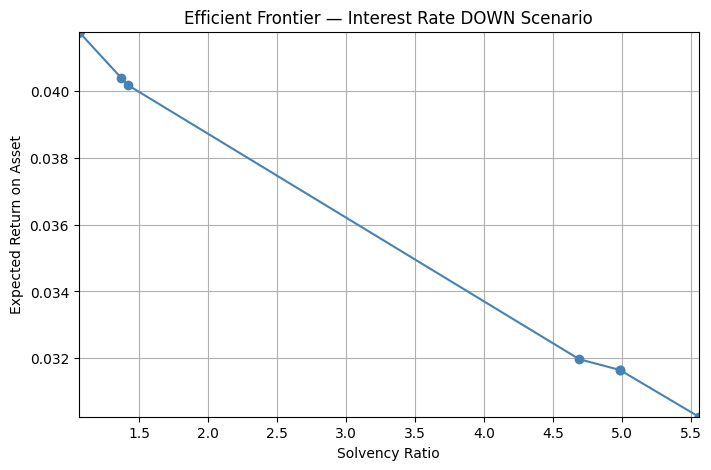

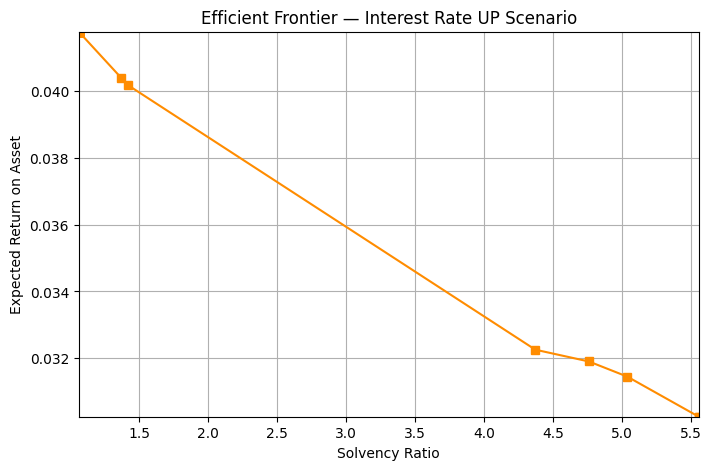

In [28]:
# =============================
#  OPTIMIZATION IN NORMALIZED FORM (weights) —
# =============================

T = asset_total  # total assets
asset_dur = np.array(initial_asset['asset_dur'], dtype=float)
lib_delta = liab_duration[0] * liab_value[0]

# --- Objective: maximize return - γ * SCR_market

def objective(x, r, gamma, R, T):
    w = x[:6]
    s = x[6:]
    port_ret = T * (w @ r)
    scr_market = np.sqrt(s @ R @ s)     # SCR (not squared)
    return - (port_ret - gamma * scr_market)


# =============================
# CAPITAL CONSTRAINTS
# =============================

def int_up_con(x):
    w = x[:6]; s_int = x[6]
    return s_int - int_up_param * (T * (asset_dur @ w) - lib_delta)

def int_down_con(x):
    w = x[:6]; s_int = x[6]
    return s_int - int_down_param * (lib_delta - T * (asset_dur @ w))

def eq_con(x):
    w = x[:6]; s_eq = x[7]
    _, _, w_eq1, w_eq2, _, _ = w
    return s_eq - T * (equity_1_param * w_eq1 + equity_2_param * w_eq2)

def prop_cont(x):
    w = x[:6]; s_prop = x[8]
    _, _, _, _, w_prop, _ = w
    return s_prop - prop_params * T * w_prop

def spread_cont(x):
    w = x[:6]; s_spread = x[9]
    _, w_corp, _, _, _, _ = w
    return s_spread - spread_params * T * w_corp


# Register constraints

int_up_constraint   = NonlinearConstraint(int_up_con, 0, np.inf)
int_down_constraint = NonlinearConstraint(int_down_con, 0, np.inf)
eq_constraint       = NonlinearConstraint(eq_con, 0, np.inf)
prop_constraint     = NonlinearConstraint(prop_cont, 0, np.inf)
spread_constraint   = NonlinearConstraint(spread_cont, 0, np.inf)


# =============================
# INVESTMENT CONSTRAINTS
# =============================

# 1. Budget: sum of weights = 1

A_mat = np.zeros((1, 10))
A_mat[0, :6] = 1
budget_constraint = LinearConstraint(A_mat, [1.0], [1.0])

# 2. Allocation limits (directly in weights)

A_mat_alloc = np.zeros((4, 10))
A_mat_alloc[0, 0]      = 1          # gov
A_mat_alloc[1, [2, 3, 4]] = 1       # illiquid = eq1 + eq2 + prop
A_mat_alloc[2, 5]      = 1          # t-bills
A_mat_alloc[3, 1]      = 1          # corp

alloc_constraint = LinearConstraint(
    A_mat_alloc,
    lb = allocation_limits["min_weight"].values,
    ub = allocation_limits["max_weight"].values,
)

constraints = [
    int_up_constraint,
    int_down_constraint,
    eq_constraint,
    prop_constraint,
    spread_constraint,
    budget_constraint,
    alloc_constraint,
]

# =============================
# FRONTIER SOLVER FUNCTION
# =============================

def solve_frontier(R_penalty, scenario_label):
    results = []
    gammas = np.logspace(-8, 0, 40)

    w0 = np.ones(6) / 6
    s0 = np.ones(4) * 0.1
    x0 = np.concatenate([w0, s0])
    r = initial_asset['asset_ret'].values

    for gamma in gammas:
        bounds = Bounds(lb=np.zeros(10), ub=np.full(10, np.inf))

        res = minimize(
            objective, x0,
            args=(r, gamma, R_penalty, T),
            constraints=constraints,
            method='SLSQP',
            bounds=bounds,
        )

        w_opt = res.x[:6]
        s_opt = res.x[6:]
        A_opt = w_opt * T
        port_return = w_opt @ r
        scr_penalty = np.sqrt(s_opt @ R_penalty @ s_opt)

        # Compute actual SCR components

        scr_interest = scr_interest_rate(
            A_opt,
            initial_asset['asset_dur'],
            liab_value,
            liab_duration,
            int_down_param,
            int_up_param,
        )

        A_eq1, A_eq2 = A_opt[2], A_opt[3]
        A_corp, A_prop = A_opt[1], A_opt[4]

        scr_equity   = scr_eq(A_eq1, A_eq2, equity_1_param, equity_2_param, rho)
        scr_property = A_prop * prop_params
        scr_spread   = A_corp * spread_params

        scr_total = aggregate_market_scr(
            scr_interest,
            scr_equity,
            scr_property,
            scr_spread,
            corr_downward,
            corr_upward,
        )['SCR_market_final']

        solvency_ratio = (T - liab_value[0]) / scr_total

        results.append({
            "gamma": gamma,
            "scenario": scenario_label,
            "objective": -res.fun,
            "return": port_return,
            "A_opt": A_opt,
            "w_opt": w_opt,
            "s_opt": s_opt,
            "SCR_penalty": scr_penalty,
            "SCR_market": scr_total,
            "solvency": solvency_ratio,
        })

    return pd.DataFrame(results)


# =============================
# RUN BOTH SCENARIOS
# =============================

opt_down = solve_frontier(corr_downward.values, "Interest_DOWN")
opt_up   = solve_frontier(corr_upward.values,   "Interest_UP")

# Plotting each scenario separately

xmin = min(opt_down["solvency"].min(), opt_up["solvency"].min())
xmax = max(opt_down["solvency"].max(), opt_up["solvency"].max())
ymin = min(opt_down["return"].min(), opt_up["return"].min())
ymax = max(opt_down["return"].max(), opt_up["return"].max())

# Downward plot

plt.figure(figsize=(8,5))
plt.plot(opt_down["solvency"], opt_down["return"], marker="o", color="steelblue")
plt.xlabel("Solvency Ratio")
plt.ylabel("Expected Return on Asset")
plt.title("Efficient Frontier — Interest Rate DOWN Scenario")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)
plt.show()

# Upward plot

plt.figure(figsize=(8,5))
plt.plot(opt_up["solvency"], opt_up["return"], marker="s", color="darkorange")
plt.xlabel("Solvency Ratio")
plt.ylabel("Expected Return on Asset")
plt.title("Efficient Frontier — Interest Rate UP Scenario")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)
plt.show()